In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from keras.api.optimizers import Adam
from keras import layers, models, utils, losses
import keras
import random
from keras.api.utils import image_dataset_from_directory
from PIL import Image
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [7]:
class CustomDataGen(keras.utils.Sequence):
    def __init__(self, data_folder: str, aug_len: dict[str, float], batch_size=32, workers=1, use_multiprocessing=False, max_queue_size=10, split="train", train_ratio=0.8, seed=42):
        super().__init__(workers, use_multiprocessing, max_queue_size)

        self.data_folder = data_folder
        self.aug_len = aug_len
        self.batch_size = batch_size
        self.data = []

        self.pipeline = tf.keras.Sequential([
            keras.layers.RandomFlip("horizontal_and_vertical"),
            keras.layers.RandomRotation(0.2),
            keras.layers.RandomZoom(0.1),
            keras.layers.RandomContrast(0.01),
            keras.layers.Rescaling(1./255),
            keras.layers.Normalization(
                mean=(0.485, 0.456, 0.406), 
                variance=(0.229, 0.224, 0.225)
            ),
            keras.layers.Resizing(224, 224)
        ])

        self.split = split
        self.train_ratio = train_ratio
        self.seed = seed
        self.load_data()

    
    def load_data(self):

        all_files = []
        for root, _, files in os.walk(self.data_folder):
            subfolder = os.path.basename(root)
            for file in files:
                all_files.append({
                    "path": os.path.join(root, file),
                    "label": subfolder
                })

        random.seed(self.seed)
        random.shuffle(all_files)
        

        split_idx = int(len(all_files) * self.train_ratio)
        

        if self.split == "train":
            base_files = all_files[:split_idx]
        else:
            base_files = all_files[split_idx:]
        
        self.data = []
        for file in base_files:
            if self.split == "train" and file["label"] in self.aug_len:
                prob = self.aug_len[file["label"]]
                for _ in range(int(prob)):
                    self.data.append(file)
                if np.random.rand() < (prob - int(prob)):
                    self.data.append(file)
            else:
                self.data.append(file)
        
        random.shuffle(self.data)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []
        for item in batch_data:
            img = Image.open(item["path"])
            img = np.array(img)
            img = self.pipeline(img)
            batch_images.append(img)
            batch_labels.append(item["label"])
        return np.array(batch_images), np.array(batch_labels)
    
    def on_epoch_end(self):
        self.load_data()
        random.shuffle(self.data)

In [8]:
train = CustomDataGen("/home/shared/Mammiferes_jpg", {"cat": 1.5, "dog": 1.5}, batch_size=8, split="train")
test = CustomDataGen("/home/shared/Mammiferes_jpg", {"cat": 1.5, "dog": 1.5}, batch_size=8, split="test")

In [245]:
model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(13, activation='softmax')
])

In [247]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [248]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [249]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses.sparse_categorical_crossentropy,
    metrics= ["accuracy"]
)

In [250]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.0802 - loss: 701.0527 - val_accuracy: 0.1200 - val_loss: 366.2226
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0346 - loss: 703.4725 - val_accuracy: 0.1000 - val_loss: 97.3537
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1167 - loss: 168.1349 - val_accuracy: 0.0400 - val_loss: 2.5951
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0419 - loss: 9.5112 - val_accuracy: 0.0800 - val_loss: 2.5809
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0812 - loss: 2.5650 - val_accuracy: 0.0800 - val_loss: 2.5852
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0994 - loss: 2.5649 - val_accuracy: 0.0800 - val_loss: 2.5876
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0931 - loss: 8.0103 - val_accuracy: 0.1000 - val_loss: 2.5889
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0947 - loss: 2.5649 - val_accuracy: 0.1000 - val_los

/tmp/ipykernel_9834/249678511.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


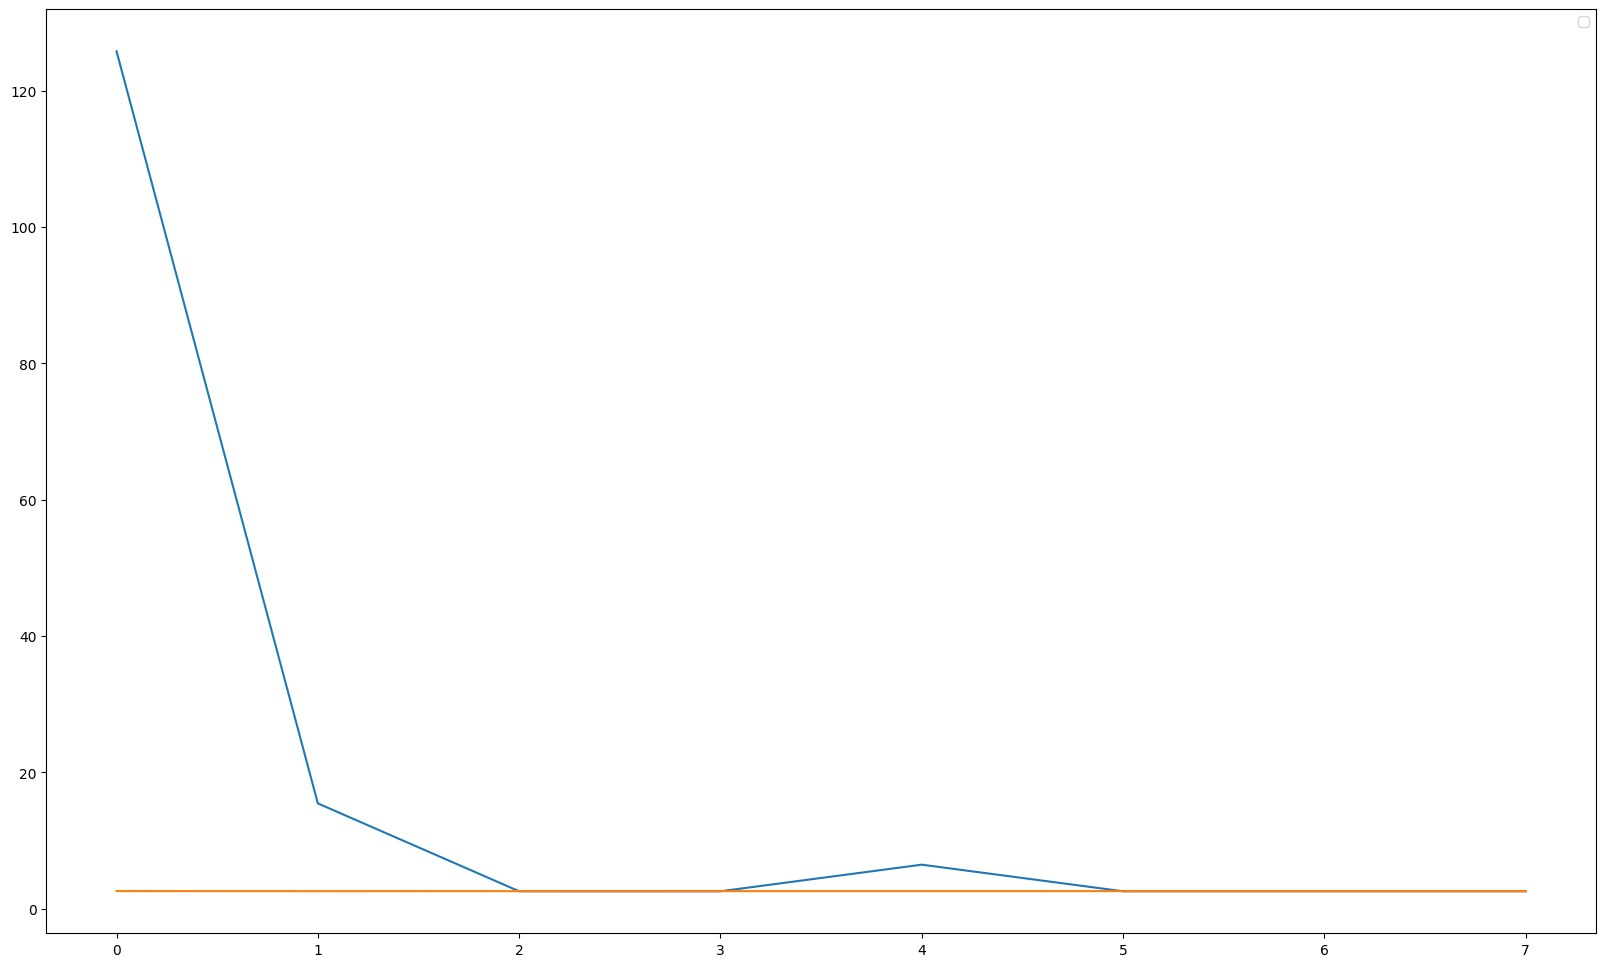

In [251]:
plt.figure(figsize=(20,12))
plt.plot(history.history["loss"][2:10])
plt.plot(history.history["val_loss"][2:10])
plt.legend()

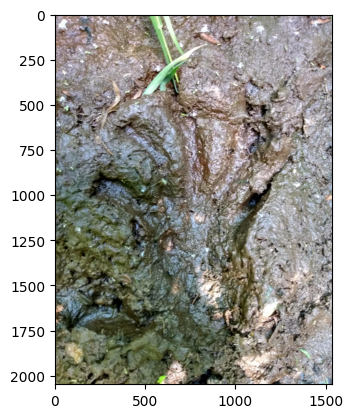

In [252]:
plt.imshow(Image.open("/home/shared/Mammiferes/Castor/original.jpeg"))

In [253]:
castor = tf.io.read_file("/home/shared/Mammiferes/Castor/original.jpeg")
castor = tf.image.decode_jpeg(castor, channels=3)
resized_castor = tf.image.resize(castor, [256,256], method="bilinear")

In [254]:
input = tf.expand_dims(
    resized_castor,
    axis = 0
)

In [255]:
input.shape

TensorShape([1, 256, 256, 3])

In [256]:
model.predict(input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


array([[0.07686731, 0.07689582, 0.07719625, 0.07686729, 0.07693707,
        0.07664924, 0.07689521, 0.07720153, 0.07693214, 0.07699014,
        0.07643367, 0.07706243, 0.07707186]], dtype=float32)

In [137]:
next(iter(val_ds))[0].shape

TensorShape([32, 256, 256, 3])

In [200]:
class_names = train_ds.class_names
print(class_names)

['Castor', 'Chat', 'Chien', 'Coyote', 'Ecureuil', 'Lapin', 'Loup', 'Lynx', 'Ours', 'Puma', 'Rat', 'Raton_laveur', 'Renard']


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

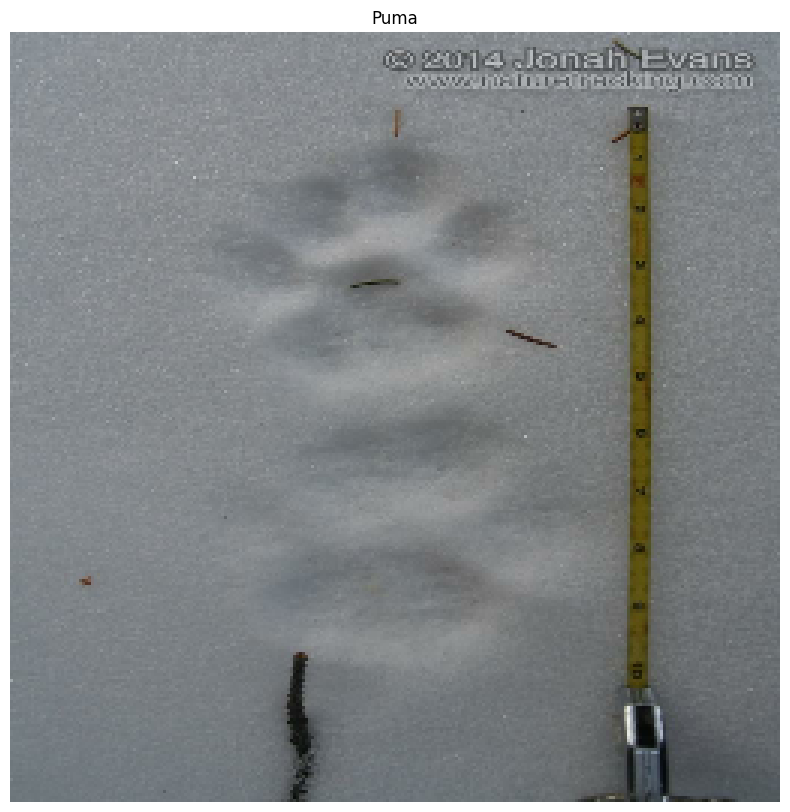

In [218]:
plt.figure(figsize=(10, 10))
batch,_ = val_ds.take(3)
image_to_test = batch[0][1].numpy().astype("uint8")
plt.imshow(image_to_test)
plt.title(class_names[batch[1][1]])
plt.axis("off")

In [214]:
input_to_test = tf.expand_dims(
    image_to_test,
    axis = 0
)

In [215]:
model.predict(input_to_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


array([[2.0761195e-06, 3.1792203e-07, 2.4042885e-01, 9.8549351e-03,
        1.0244539e-06, 6.3650399e-01, 4.8411516e-03, 2.6146506e-04,
        1.0629637e-01, 3.0404640e-10, 5.6452569e-05, 4.6649434e-06,
        1.7487474e-03]], dtype=float32)

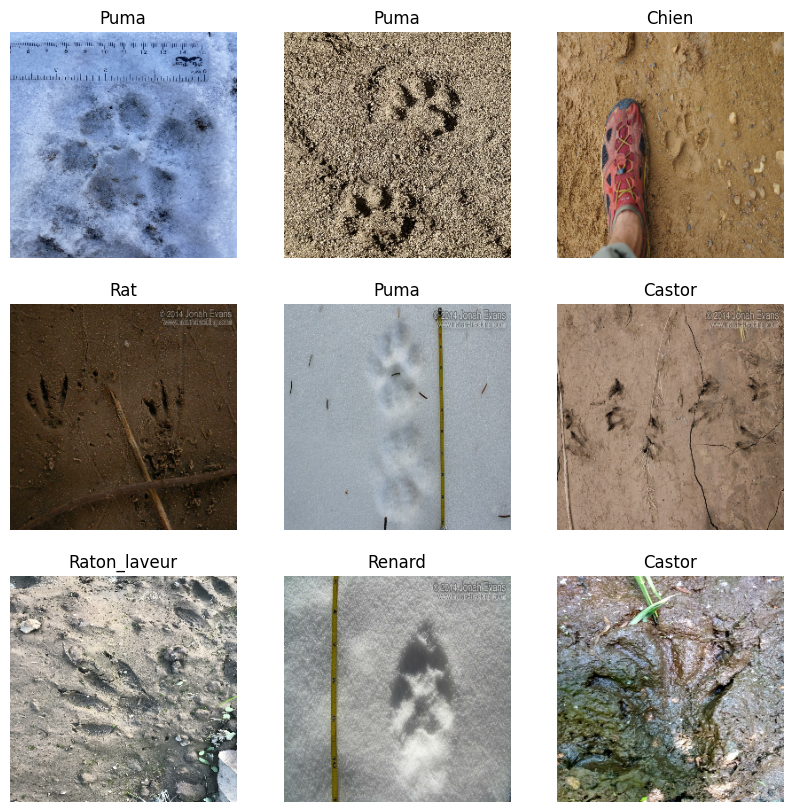

In [235]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")